В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [1]:
!pip install torch_geometric --quiet
!pip install nni --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 26.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.26.4 requires filelock>=3.15, but you have filelock 3.11.0 which is incompatible.


Импортируем необходимые библиотеки

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS,DBSCAN
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Custom imports
import sys
sys.path.insert(1, "../input/dependecies")

from Graph import Graph
from GCN import (
    GCN,
    SimpleGCN,
    GAT,
    CustomDataset,
    TripletGraphDataset,
    train_model_accuracy,
    train_model_diversity,
    get_positive_and_negative,
    extract_embeddings,
    collate_triplets,
    collate_graphs
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [2]:
DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')

Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [3]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [4]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in tqdm(files):
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [5]:
models_dict = load_json_from_directory('third_dataset')

100%|██████████| 1300/1300 [00:03<00:00, 379.96it/s]


Посмотрю как распределена точность моделей

0.9009


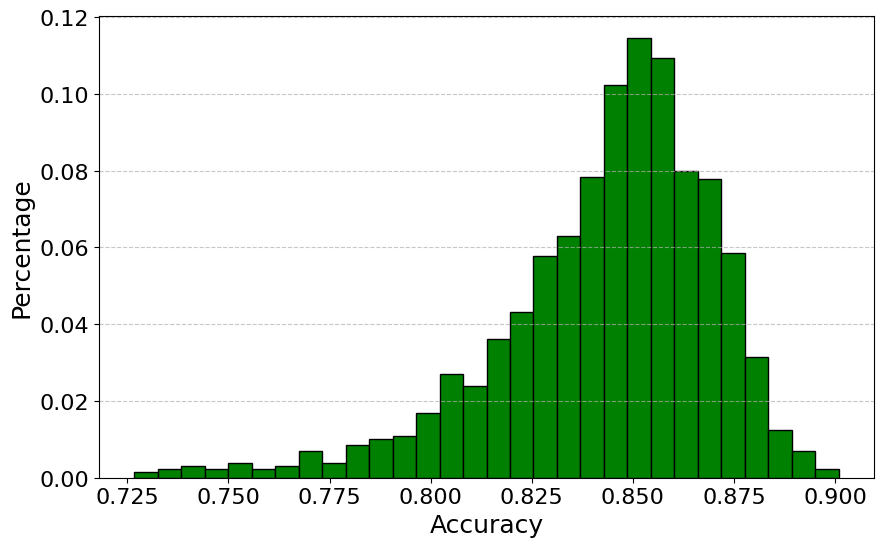

In [7]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=30, edgecolor='black', color="green", weights=[1/len(accuracies)]*len(accuracies))
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
print(np.max(accuracies))
plt.show()

In [8]:
graph = Graph(models_dict[1])

Посмотрю как выглядит граф.

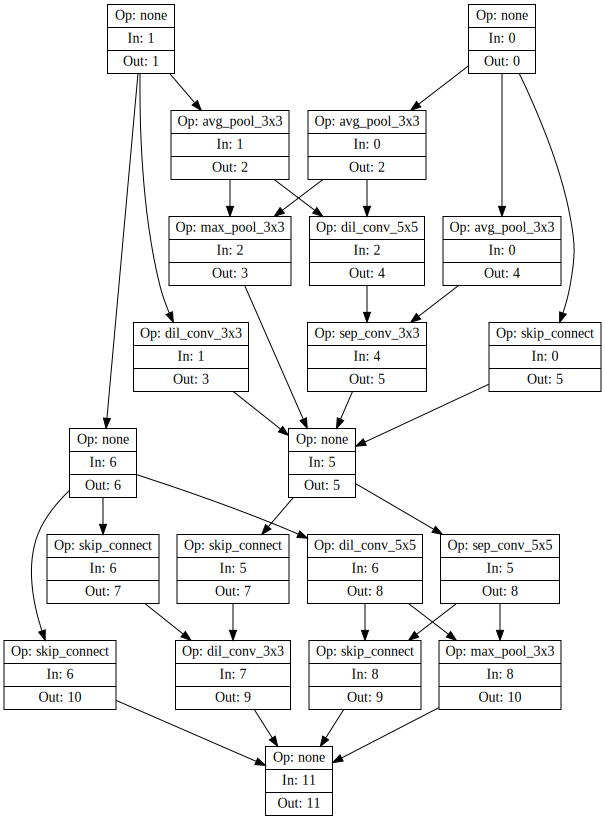

In [9]:
graph.show_graph()

In [10]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [11]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: avg_pool_3x3 | In: 0 | Out: 2,
 Op: avg_pool_3x3 | In: 0 | Out: 4,
 Op: skip_connect | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: avg_pool_3x3 | In: 1 | Out: 2,
 Op: dil_conv_3x3 | In: 1 | Out: 3,
 Op: max_pool_3x3 | In: 2 | Out: 3,
 Op: dil_conv_5x5 | In: 2 | Out: 4,
 Op: sep_conv_3x3 | In: 4 | Out: 5]

In [12]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: skip_connect | In: 0 | Out: 2,
 Op: sep_conv_5x5 | In: 0 | Out: 3,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: dil_conv_5x5 | In: 1 | Out: 3,
 Op: skip_connect | In: 1 | Out: 5,
 Op: dil_conv_3x3 | In: 2 | Out: 4,
 Op: skip_connect | In: 3 | Out: 4,
 Op: max_pool_3x3 | In: 3 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [13]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [14]:
def get_diversity(args):
    i, j, model_i, model_j = args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_using_jensen_shannon(args):
    i, j, model_i, model_j= args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean([np.sqrt(jensenshannon(p1, p2)) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [15]:
def get_diversity_matrix_naive(models_dict, num_samples=None):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(cached_preds[i] == cached_preds[j])
            diversity_matrix[i, j] = diversity_matrix[j, i] = distance

    return diversity_matrix

def get_diversity_matrix(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(np.sqrt(jensenshannon(cached_preds[i], cached_preds[j])))
            diversity_matrix[i, j] = distance
            diversity_matrix[j, i] = distance

    return diversity_matrix

In [17]:
diversity_matrix = get_diversity_matrix_naive(models_dict)

Computing diversity matrix: 100%|██████████| 1300/1300 [00:22<00:00, 56.85it/s] 


100%|██████████| 1300/1300 [00:00<00:00, 4803.49it/s]


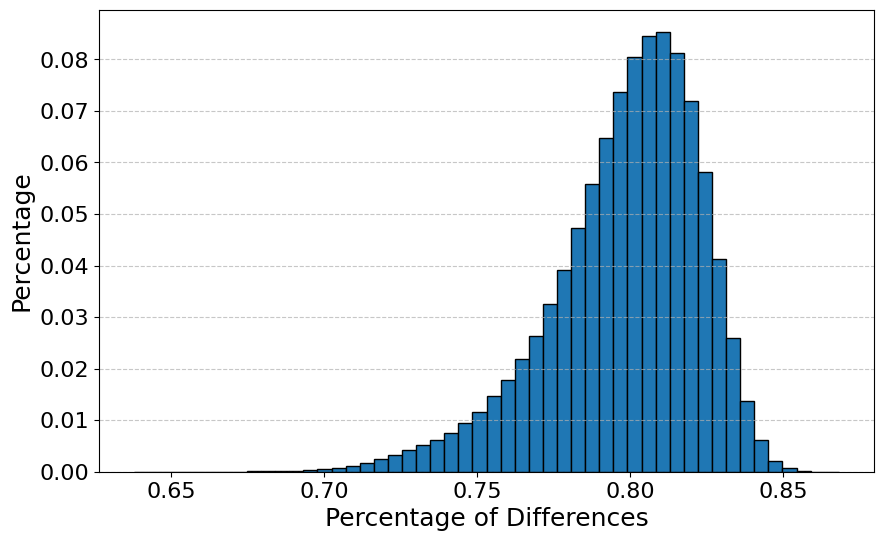

In [18]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=50, edgecolor="black", weights=np.ones(len(diversities)) / len(diversities))
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Percentage", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [19]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.8, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.2, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [20]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Строим тренировочный и валидационный датасеты.

In [21]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

base_train_dataset, base_valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(base_train_dataset)}")
print(f"Test dataset size: {len(base_valid_dataset)}")

Train dataset size: 1040
Test dataset size: 260


In [22]:
train_dataset = TripletGraphDataset(base_train_dataset, discrete_diversity_matrix)
valid_dataset = TripletGraphDataset(base_valid_dataset, discrete_diversity_matrix)
full_triplet_dataset = TripletGraphDataset(graphs_dataset, discrete_diversity_matrix)

BATCH_SIZE = 8

train_loader_diversity = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_triplets,
)

valid_loader_diversity = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_triplets,
)

train_loader_accuracy = DataLoader(
    base_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_graphs,
)

valid_loader_accuracy = DataLoader(
    base_valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_graphs,
)

Обучим модель предсказывать точность по архитектуре.

In [37]:
input_dim = graphs_dataset[0]["x"].shape[1]
output_dim = 1
num_epochs = 30

model_accuracy = GAT(input_dim, output_dim=output_dim, dropout=0.4, heads=16)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-2)
criterion = nn.MSELoss()

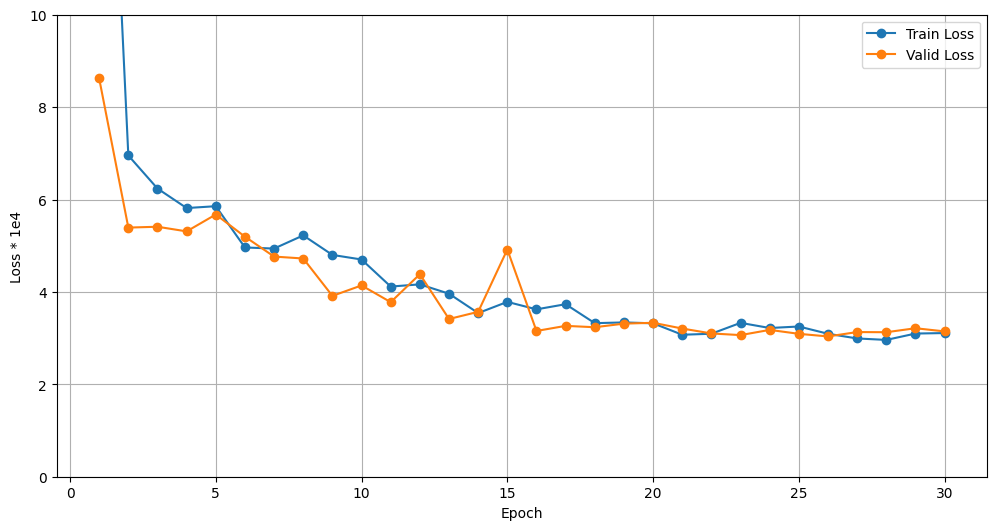

Epoch 30, Train Loss: 3.1095, Valid Loss: 3.1456, LR: 0.000156


In [38]:
train_model_accuracy(
    model_accuracy,
    train_loader_accuracy,
    valid_loader_accuracy,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [25]:
embeddings = extract_embeddings(model_accuracy, valid_loader_accuracy, device=device)[0]

for i, data in enumerate(valid_loader_accuracy):
    index = data.index
    accuracy = data.y
    accuracy_values = accuracy.cpu().numpy()

    mask = (accuracy_values > 0.87) | (accuracy_values < 0.83)
    accuracy_values = accuracy_values[mask]
    index = index[mask] 

    for j in range(len(accuracy_values)):
        embedding_index = i * BATCH_SIZE + j
        print(f"Index: {index[j]:04d}, Accuracy: {accuracy_values[j]:.3f}, Embedding: {embeddings[embedding_index].mean():.3f}")
        
        if j >= 20:
            break

    if i * BATCH_SIZE > 20:
        break


  0%|          | 0/33 [00:00<?, ?it/s]

Index: 0497, Accuracy: 0.880, Embedding: 0.850
Index: 1302, Accuracy: 0.881, Embedding: 0.845
Index: 0179, Accuracy: 0.822, Embedding: 0.858
Index: 0957, Accuracy: 0.872, Embedding: 0.859
Index: 0506, Accuracy: 0.814, Embedding: 0.839
Index: 0627, Accuracy: 0.889, Embedding: 0.852
Index: 0384, Accuracy: 0.824, Embedding: 0.856
Index: 0853, Accuracy: 0.811, Embedding: 0.862
Index: 0566, Accuracy: 0.796, Embedding: 0.860
Index: 1292, Accuracy: 0.826, Embedding: 0.843
Index: 1357, Accuracy: 0.871, Embedding: 0.857
Index: 0980, Accuracy: 0.807, Embedding: 0.835


In [26]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [27]:
input_dim = graphs_dataset[0]["x"].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 128
num_epochs = 30

model = GAT(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

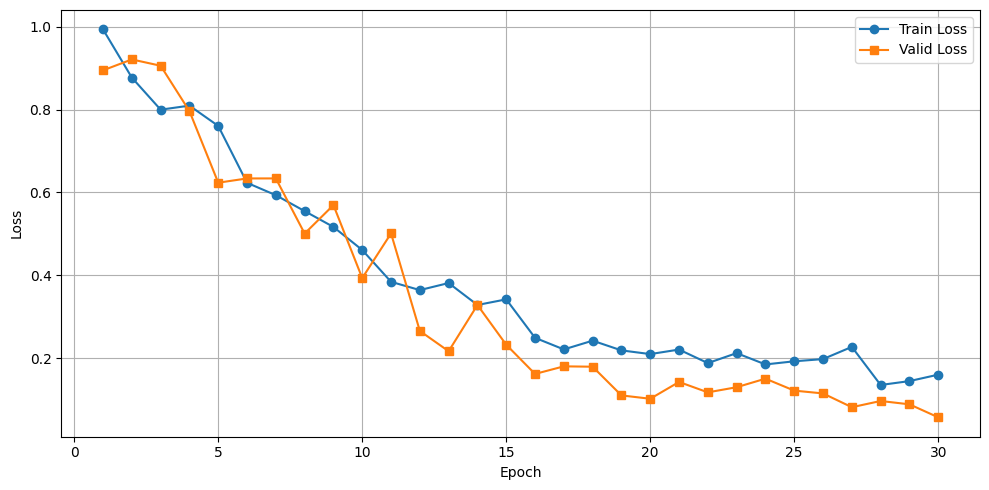

Epoch 30/30 — Train Loss: 0.1600, Valid Loss: 0.0569, LR: 0.000016


In [28]:
train_model_diversity(
    model,
    train_loader_diversity,
    valid_loader_diversity,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [29]:
def visualize_clusters(model, train_loader, device="cpu", min_samples=3, eps=0.025):
    # Извлечение эмбеддингов
    embeddings, indices = extract_embeddings(model, train_loader, device=device)
    
    # Преобразование эмбеддингов в 2D с помощью PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Кластеризация с помощью OPTICS
    # optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
    # clusters = optics.fit_predict(embeddings)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    clusters = dbscan.fit_predict(embeddings)
    
    # Визуализация кластеров
    plt.figure(figsize=(8, 6.5))
    scatter = plt.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=clusters, 
        cmap='tab10',  
        s=np.where(clusters == -1, 20, 70),  
        alpha=np.where(clusters == -1, 0.5, 1)
    )
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    
    # Создание легенды для кластеров
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        if cluster == -1:
          label = "Noise"
        else:
          label = f"Cluster {cluster}"
        plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label ,  s=50 if cluster != -1 else 20)
    
    plt.gca().set_facecolor('lightgrey')
    # plt.legend()
    plt.show()
    
    return clusters

  0%|          | 0/130 [00:00<?, ?it/s]

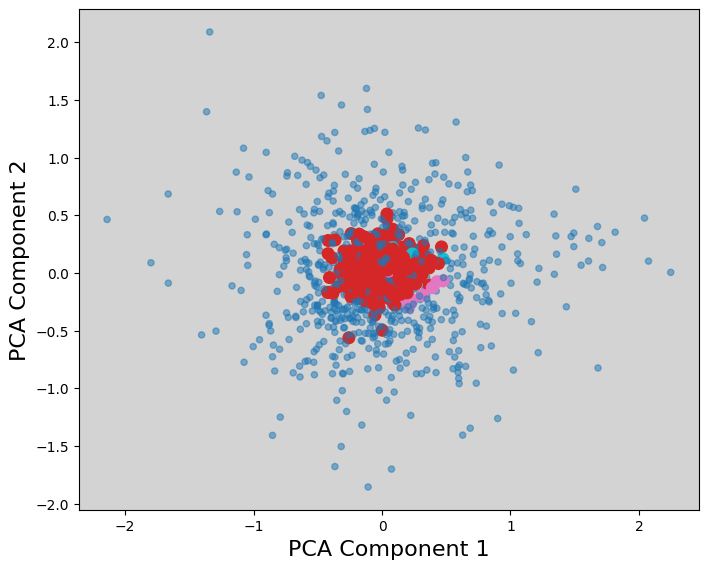

In [30]:
clusters = visualize_clusters(
  model,
  train_loader_diversity,
  device=device,
  min_samples=3,
  eps=0.6,
)

In [31]:
embeddings[0]

0.8501845

In [32]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for sample in dataset:
            x = sample.x.to(device)
            edge_index = sample.edge_index.to(device)
            batch = sample.batch if hasattr(sample, "batch") else None  # если batch'и не заданы

            embedding = model(x, edge_index, batch=batch).cpu().numpy().reshape(-1)
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    # Вычисление попарных евклидовых расстояний
    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    # Массив архитектур
    architectures = [models_dict[index] for index in dataset.indices]

    # Заполнение similarity matrix по индексам архитектур
    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i].index
            arch_j_index = dataset[j].index

            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    # Только верхний треугольник
    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation_pearson, _ = pearsonr(embedding_distances, similarity_values)
    correlation_spearman, _ = spearmanr(embedding_distances, similarity_values)

    return correlation_pearson, correlation_spearman

input_dim = graphs_dataset[0]["x"].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 128
num_epochs = 30

model = GAT(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)Рассчитаю корреляции

In [33]:
pearson_correlation, spearman_correlation = compute_correlation(
    models_dict, base_valid_dataset, model, diversity_matrix, device=device
)

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")
print(f"Корреляция Спирмена: {spearman_correlation:.3f}")

Computing similarity matrix: 100%|██████████| 260/260 [00:03<00:00, 66.72it/s] 

Корреляция Пирсона: -0.384
Корреляция Спирмена: -0.384


In [34]:
def compute_cluster_mean_diversities(
    clusters: np.ndarray,
    diversity_matrix: np.ndarray,
    discrete_diversity_matrix: np.ndarray,
    min_samples: int = 10,
):
    """
    Для каждого кластера берёт «якорную» архитектуру (первый элемент кластера),
    затем в min_samples раз выбирает положительную и отрицательную архитектуры
    через get_positive_and_negative (по discrete_diversity_matrix),
    и усредняет заранее посчитанные отношения разнообразия из diversity_matrix.
    """
    n_clusters = len(set(clusters))
    
    for i in range(n_clusters):
        # индексы объектов, попавших в кластер i
        cluster_idxs = np.where(clusters == i)[0]
        if len(cluster_idxs) < 2:
            print(f"Cluster {i}: not enough samples.")
            continue
        
        anchor = cluster_idxs[0]
        pos_divs, neg_divs = [], []
        
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, [anchor])
            if positive is None or negative is None:
                # пропускаем, если не удалось найти пару
                continue
            
            # вместо вызова get_diversity_js просто берём готовое значение
            pos_divs.append(diversity_matrix[anchor, positive])
            neg_divs.append(diversity_matrix[anchor, negative])
        
        mean_pos = np.mean(pos_divs) if pos_divs else None
        mean_neg = np.mean(neg_divs) if neg_divs else None
        
        print(f"Cluster {i}:")
        if mean_pos is not None:
            print(f"  Mean Positive Diversity: {mean_pos:.4f}")
        else:
            print("  No positive diversity data available.")
        
        if mean_neg is not None:
            print(f"  Mean Negative Diversity: {mean_neg:.4f}")
        else:
            print("  No negative diversity data available.")
        
        # ограничиваем вывод первыми 11 кластерами
        if i >= 10:
            break
            
compute_cluster_mean_diversities(
    clusters,
    diversity_matrix,
    discrete_diversity_matrix,
    min_samples=10,
)

Cluster 0:
  Mean Positive Diversity: 0.8388
  Mean Negative Diversity: 0.7826
Cluster 1:
  Mean Positive Diversity: 0.8401
  Mean Negative Diversity: 0.7823
Cluster 2:
  Mean Positive Diversity: 0.8205
  Mean Negative Diversity: 0.7714
Cluster 3: not enough samples.


In [35]:
# Индексы кластеров
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

# ====== Средняя похожесть внутри первого кластера ======
n1 = len(cluster_1_indexes)
if n1 > 1:
    # Выбираем подматрицу diversity_matrix для кластер 1
    submat_1 = diversity_matrix[np.ix_(cluster_1_indexes, cluster_1_indexes)]
    # Берём только верхний треугольник без диагонали
    triu_i, triu_j = np.triu_indices(n1, k=1)
    sims_within_1 = submat_1[triu_i, triu_j]
    mean_similarity_within_cluster_1 = np.mean(sims_within_1)
else:
    mean_similarity_within_cluster_1 = None

# ====== Средняя похожесть между кластерами 1 и 2 ======
if len(cluster_1_indexes) > 0 and len(cluster_2_indexes) > 0:
    sims_between = diversity_matrix[np.ix_(cluster_1_indexes, cluster_2_indexes)]
    mean_similarity_between_clusters = np.mean(sims_between)
else:
    mean_similarity_between_clusters = None

# ====== Результаты ======
if mean_similarity_within_cluster_1 is not None:
    print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
else:
    print("В первом кластере недостаточно элементов для расчёта похожести.")

if mean_similarity_between_clusters is not None:
    print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")
else:
    print("Недостаточно элементов в одном из кластеров для расчёта межкластерной похожести.")

Средняя похожесть внутри первого кластера: 0.8065
Средняя похожесть между первым и вторым кластерами: 0.8103


In [36]:
abort()

NameError: name 'abort' is not defined

In [ ]:
final_loader_accuracy = DataLoader(
    graphs_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_graphs,
    num_workers=4,
)

final_loader_diversity = DataLoader(
    full_triplet_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_triplets,
    num_workers=4,
)

In [ ]:
abort()

In [ ]:
input_dim = graphs_dataset[0]["x"].shape[1]
output_dim = 1
num_epochs = 30

model_accuracy = GAT(input_dim, output_dim=output_dim, dropout=0.4, heads=16)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-2)
criterion = nn.MSELoss()

train_model_accuracy(
    model_accuracy,
    final_loader_accuracy,
    final_loader_accuracy,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [ ]:
input_dim = graphs_dataset[0]["x"].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 128
num_epochs = 30

model = GAT(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

train_model_diversity(
    model,
    final_loader_diversity,
    valid_loader_diversity,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [ ]:
torch.save(model.state_dict(), "model_diversity_weights.pth")
torch.save(model_accuracy.state_dict(), "model_accuracy_weights.pth")

In [ ]:
!zip weights model_diversity_weights.pth model_accuracy_weights.pth